In [218]:
import pandas as pd 
import numpy as np 
import nltk
import nltk.corpus
from nltk.corpus import words
from nltk.tokenize import WhitespaceTokenizer
import matplotlib.pyplot as plt
import random

from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Preprocessing Dataset

In [219]:
data_path = '/Users/abdoulabdillahi/Desktop/CSC 680/Final_project/chat_slang/data/slang.csv'
df = pd.read_csv(data_path)

In [220]:
df.shape

(3357, 3)

In [221]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,acronym,expansion
0,2day,today
1,2m2h,too much too handle
2,2moro,tomorrow
3,2nite,tonight
4,4eae,for ever and ever


In [222]:
def generate_text_with_acronyms(df, num_sentences=5, num_acronyms_to_use=5):
    sentences = []
    for _ in range(num_sentences):
        sentence = []
        # Randomly choose acronyms and use them in the sentence
        sampled_acronyms = random.sample(range(len(df)), min(num_acronyms_to_use, len(df)))
        for idx in sampled_acronyms:
            acronym, expansion = df.iloc[idx]['acronym'], df.iloc[idx]['expansion']
            # Construct the sentence using the acronym and its expansion
            sentence.append(random.choice([acronym, expansion]))
        sentences.append(" ".join(sentence))
    return " ".join(sentences)

In [223]:
# creating a new column to generate synthetic text 
df['informal_text'] = df.apply( lambda row:generate_text_with_acronyms(df, num_sentences=1, num_acronyms_to_use=5), axis=1)

In [224]:
pd.set_option('display.max_colwidth', 255)

In [225]:
df.head(10)

,acronym,expansion,informal_text
0,2day,today,asap xlnt advanced research projects agency network recreational vehicle url
1,2m2h,too much too handle,mp if i understand correctly other peoples business nik national hockey league
2,2moro,tomorrow,vhs temporarily deployed for a year but i could be wrong lbd any time now
3,2nite,tonight,big bad evil guy i will think about it moq in your dreams the one that got away
4,4eae,for ever and ever,imco warner music group teotwawki the frozen throne thin film transistor my heart bleeds for you
5,aaf,as a friend,who wants to be a millionaire yw not even going to lie pdp imsmr
6,aar,at any rate,will see you later ateotd gun shot wound mas hit me up later
7,aayf,as always your friend,angels forever forever angels bmg mw3 in love mdk
8,abd,already been done,american eagle you always live again nabd tybg amn
9,ack,acknowledge,thick rich and white wby it is what i do obsessive compulsive disorder ijwtk


In [226]:
# Tokenisation
tokenizer = WhitespaceTokenizer()
def tokenise(text):
    return tokenizer.tokenize(str(text))

df['tokenized_text'] = df['informal_text'].apply(lambda x: tokenise(x))

In [227]:
# Define a replace informal function to formal 
def replace_informal(tokens, informal):
    tokens = [informal.get(token.lower(), token) for token in tokens]
    return ' '.join(tokens)

In [228]:
# apply replace informal function to the
def formalize_dataframe(df, informal):
    df['formal_text'] = df['tokenized_text'].apply(lambda x: replace_informal(x, informal))
    return df

In [229]:
# Mapping dictionnary from acronyms and their expansion 
informal_to_formal = dict(zip(df['acronym'], df['expansion']))

In [230]:
df= formalize_dataframe(df, informal_to_formal)

In [231]:
df.head()

,acronym,expansion,informal_text,tokenized_text,formal_text
0,2day,today,asap xlnt advanced research projects agency network recreational vehicle url,"[asap, xlnt, advanced, research, projects, agency, network, recreational, vehicle, url]",as soon as possible excellent advanced research projects agency network recreational vehicle uniform resource locator internet address
1,2m2h,too much too handle,mp if i understand correctly other peoples business nik national hockey league,"[mp, if, i, understand, correctly, other, peoples, business, nik, national, hockey, league]",military police member of parliament if i understand correctly other peoples business now i know national hockey league
2,2moro,tomorrow,vhs temporarily deployed for a year but i could be wrong lbd any time now,"[vhs, temporarily, deployed, for, a, year, but, i, could, be, wrong, lbd, any, time, now]",video home system temporarily deployed for a year but i could be wrong little black dress any tears in my eyes now
3,2nite,tonight,big bad evil guy i will think about it moq in your dreams the one that got away,"[big, bad, evil, guy, i, will, think, about, it, moq, in, your, dreams, the, one, that, got, away]",big bad evil guy i will think about information technology minimum order quantity in your dreams the one that got away
4,4eae,for ever and ever,imco warner music group teotwawki the frozen throne thin film transistor my heart bleeds for you,"[imco, warner, music, group, teotwawki, the, frozen, throne, thin, film, transistor, my, heart, bleeds, for, you]",in my considered opinion warner music group the end of the world as we know it the frozen throne thin film transistor miss you heart bleeds for you


# Data Transformation and Label Assignment 

In [232]:
# Creating informal dataframe 
informal_df = pd.DataFrame({'Text': df['informal_text'], 'Label': 0})

In [233]:
formal_df = pd.DataFrame({'Text': df['formal_text'], 'Label':1})

In [234]:
# combined the two Dataframe 
combined_df = pd.concat([informal_df, formal_df], ignore_index=True)

In [235]:
combined_df.head()

,Text,Label
0,asap xlnt advanced research projects agency network recreational vehicle url,0
1,mp if i understand correctly other peoples business nik national hockey league,0
2,vhs temporarily deployed for a year but i could be wrong lbd any time now,0
3,big bad evil guy i will think about it moq in your dreams the one that got away,0
4,imco warner music group teotwawki the frozen throne thin film transistor my heart bleeds for you,0


In [236]:
# shuffle the DataFrame 
dframe = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [237]:
dframe.head()

,Text,Label
0,dirty money syndicate keep mum nqat holy cow imo,0
1,boy better know little black dress never heard that before look forward time out seeing you what you doing,1
2,big name fan ootd mva dsd you forever,0
3,where in the hell effect from natural born killers never been kissed weekend blind carbon copy what is the point,1
4,under the skin get a clue does not matter deep and meaningful oh my god ay que funny,1


# Feature Extraction and Training the model 

In [238]:
vectorizer = TfidfVectorizer(max_features=1500)
X = vectorizer.fit_transform(dframe['Text'])   # feature of the dataset 
y = dframe['Label']                                             # targets or labels 

In [239]:
# Split the data into training and testing the model 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [240]:
# Model Training 
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [241]:
# Model Evaluation 
predictions = model.predict(X_test)

In [242]:
# Generating classification report 
report = classification_report(y_test, predictions, output_dict=True)

In [243]:
df_report = pd.DataFrame(report).transpose()

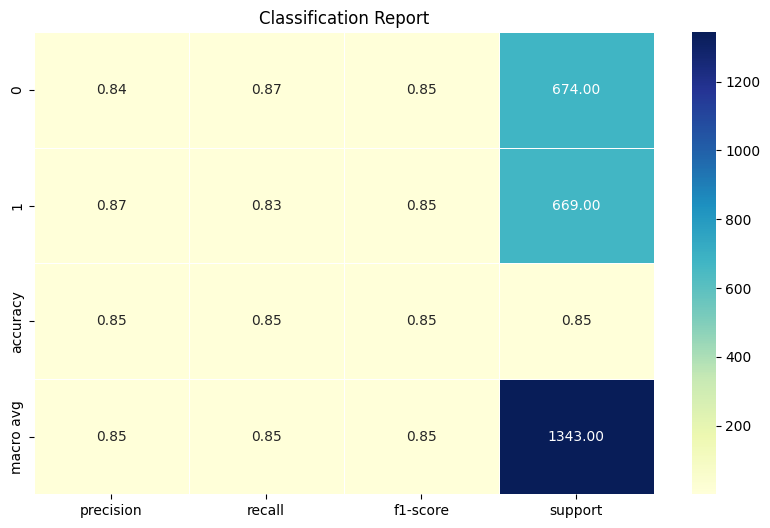

In [244]:
plt.figure(figsize=(10,6))
sns.heatmap(df_report.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("Classification Report")
plt.show()

# Second Model Logistic Regreesion 

In [245]:
# Train model 
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression()

In [246]:
# Make prediction 
y_pred = model2.predict(X_test)

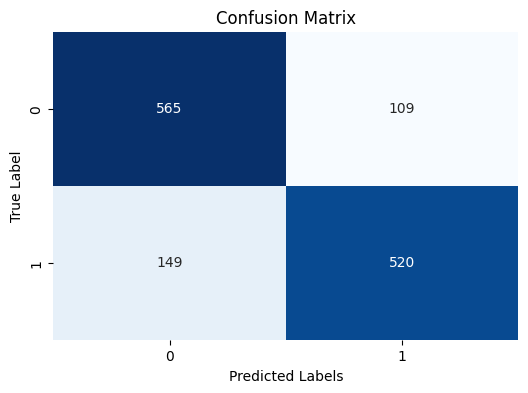

In [247]:
# Evaluate the model using Confusion Matrix 
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [248]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

Accuracy: 0.81

